In [1]:
import gymnasium as gym
from gymnasium import spaces
import json
import copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.backends.backend_agg import FigureCanvasAgg

from stable_baselines3 import A2C, PPO, DQN
from sb3_contrib import MaskablePPO
from sb3_contrib.common.wrappers import ActionMasker
from sb3_contrib.common.maskable.callbacks import MaskableEvalCallback

from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.vec_env import SubprocVecEnv, DummyVecEnv
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.logger import configure
from stable_baselines3.common.env_checker import check_env

In [2]:
from scheduler_env.customEnv_repeat import SchedulingEnv

In [3]:
import warnings
# 특정 경고를 무시하도록 필터를 설정합니다.
warnings.filterwarnings("ignore", category=Warning)

In [4]:
env = SchedulingEnv(machine_config_path= "instances/Machines/v0-2.json", job_config_path = "instances/figure/job3.json", job_repeats_params = [(2, 1)] * 3, test_mode=True)

In [5]:
env.show_job_info()

,Job Name,Mean Ops Duration,Std Ops Duration,# of Ops,Mean Deadline,Std Deadline,Repeats
0,Job 1,1.500000,0.500000,2,0.00,0.000000,2
1,Job 2,1.500000,0.500000,2,0.00,0.000000,2
2,Job 3,1.000000,0.000000,3,0.00,0.000000,2


In [6]:
env.show_env_info()

,Operation Type,Total Count,Avg Duration,Std Duration,Machine Count
0,A,8,1.25,0.43,2
1,B,6,1.33,0.47,1


Job 1 - Repeat 1 : ETD = 1.4766666666666666, D = 7
Job 1 - Repeat 2 : ETD = 1.46, D = 12
Job 2 - Repeat 1 : ETD = 2.94, D = 6
Job 2 - Repeat 2 : ETD = 1.97, D = 9
Job 3 - Repeat 1 : ETD = 1.48, D = 6
Job 3 - Repeat 2 : ETD = 1.4666666666666666, D = 10
finish_time 100


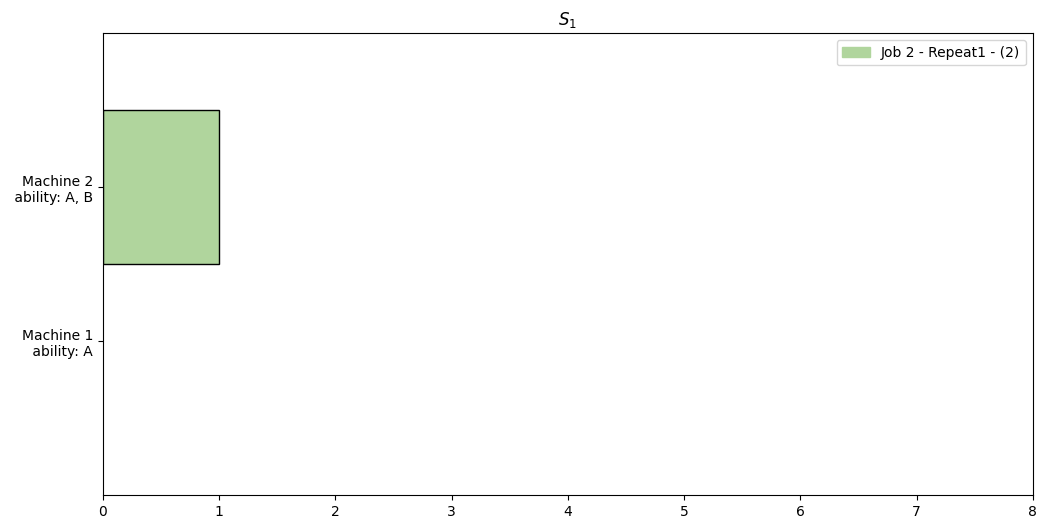

Job 1 - Repeat 1 : ETD = 1.9766666666666666, D = 7
Job 1 - Repeat 2 : ETD = 1.96, D = 12
Job 2 - Repeat 1 : ETD = 2.94, D = 6
Job 2 - Repeat 2 : ETD = 1.97, D = 9
Job 3 - Repeat 2 : ETD = 1.9666666666666666, D = 10
Job 3 - Repeat 1 : ETD = 1.96, D = 6
finish_time 100


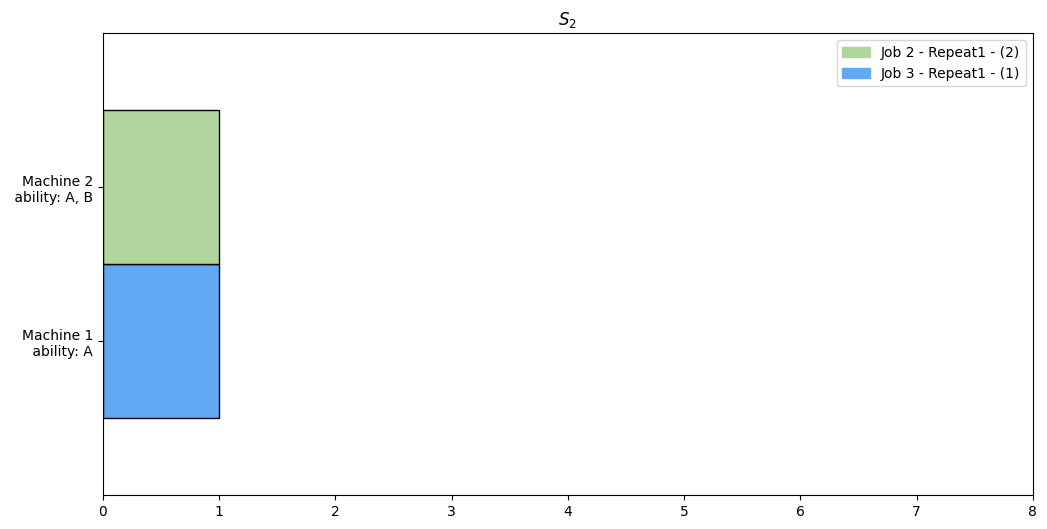

Job 1 - Repeat 1 : ETD = 2.976666666666667, D = 7
Job 1 - Repeat 2 : ETD = 2.96, D = 12
Job 2 - Repeat 2 : ETD = 1.97, D = 9
Job 2 - Repeat 1 : ETD = 2.94, D = 6
Job 3 - Repeat 2 : ETD = 2.966666666666667, D = 10
Job 3 - Repeat 1 : ETD = 1.96, D = 6
finish_time 300


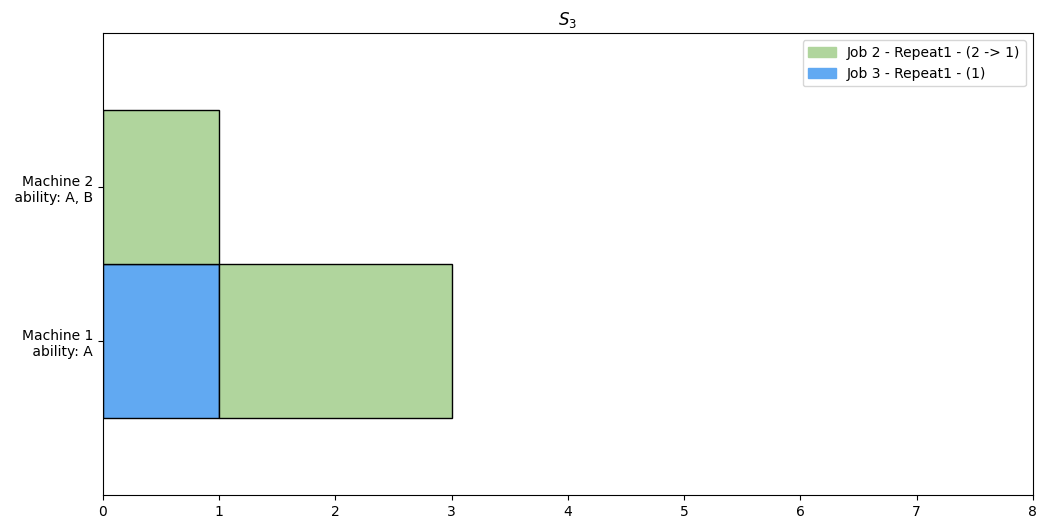

Job 1 - Repeat 1 : ETD = 5.93, D = 7
Job 1 - Repeat 2 : ETD = 3.46, D = 12
Job 2 - Repeat 2 : ETD = 1.97, D = 9
Job 2 - Repeat 1 : ETD = 2.94, D = 6
Job 3 - Repeat 2 : ETD = 3.466666666666667, D = 10
Job 3 - Repeat 1 : ETD = 1.96, D = 6
finish_time 400


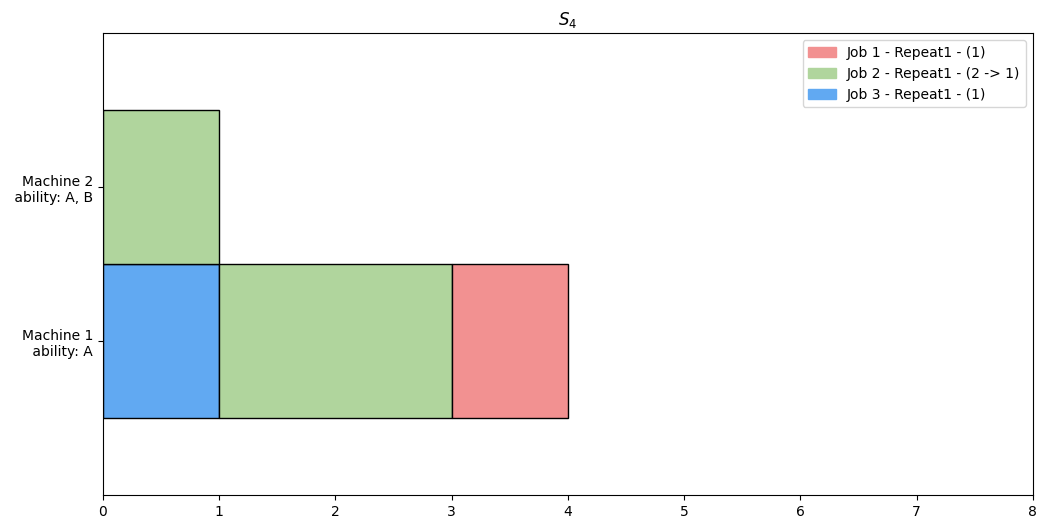

Job 1 - Repeat 2 : ETD = 3.46, D = 12
Job 1 - Repeat 1 : ETD = 5.93, D = 7
Job 2 - Repeat 2 : ETD = 1.97, D = 9
Job 2 - Repeat 1 : ETD = 2.94, D = 6
Job 3 - Repeat 2 : ETD = 3.466666666666667, D = 10
Job 3 - Repeat 1 : ETD = 1.96, D = 6
finish_time 600


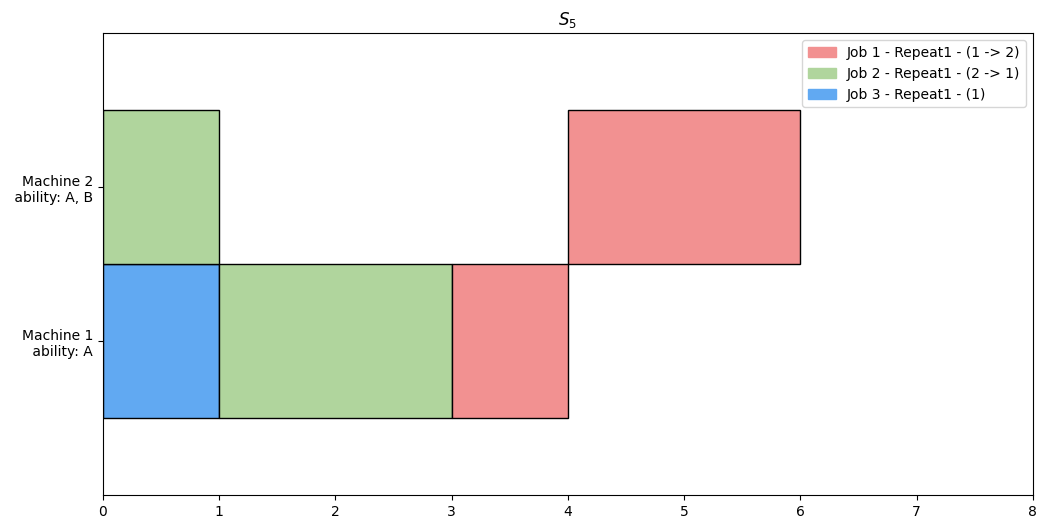

Job 1 - Repeat 2 : ETD = 3.96, D = 12
Job 1 - Repeat 1 : ETD = 5.93, D = 7
Job 2 - Repeat 2 : ETD = 1.97, D = 9
Job 2 - Repeat 1 : ETD = 2.94, D = 6
Job 3 - Repeat 2 : ETD = 6.933333333333334, D = 10
Job 3 - Repeat 1 : ETD = 1.96, D = 6
finish_time 600


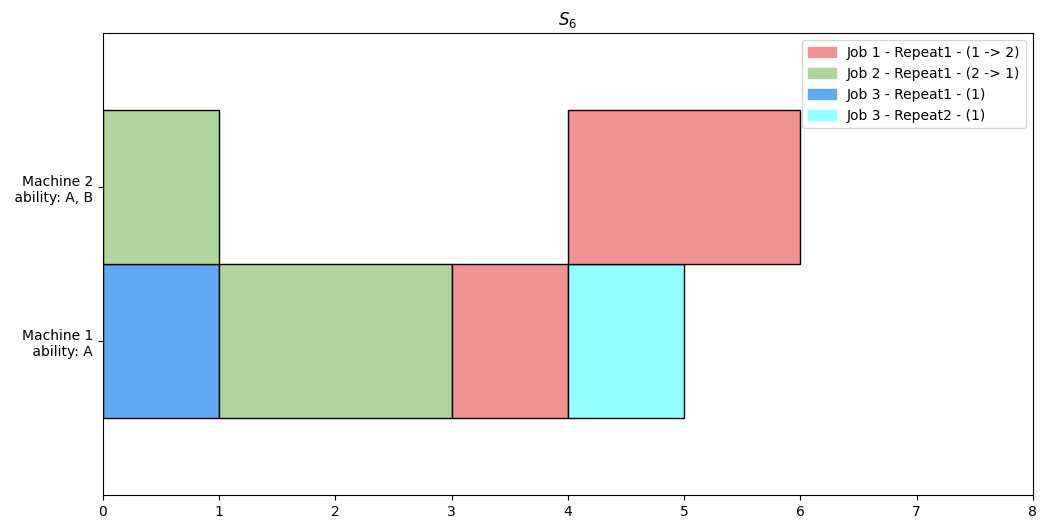

Job 1 - Repeat 2 : ETD = 3.96, D = 12
Job 1 - Repeat 1 : ETD = 5.93, D = 7
Job 2 - Repeat 2 : ETD = 1.97, D = 9
Job 2 - Repeat 1 : ETD = 2.94, D = 6
Job 3 - Repeat 2 : ETD = 7.9, D = 10
Job 3 - Repeat 1 : ETD = 1.96, D = 6
finish_time 700


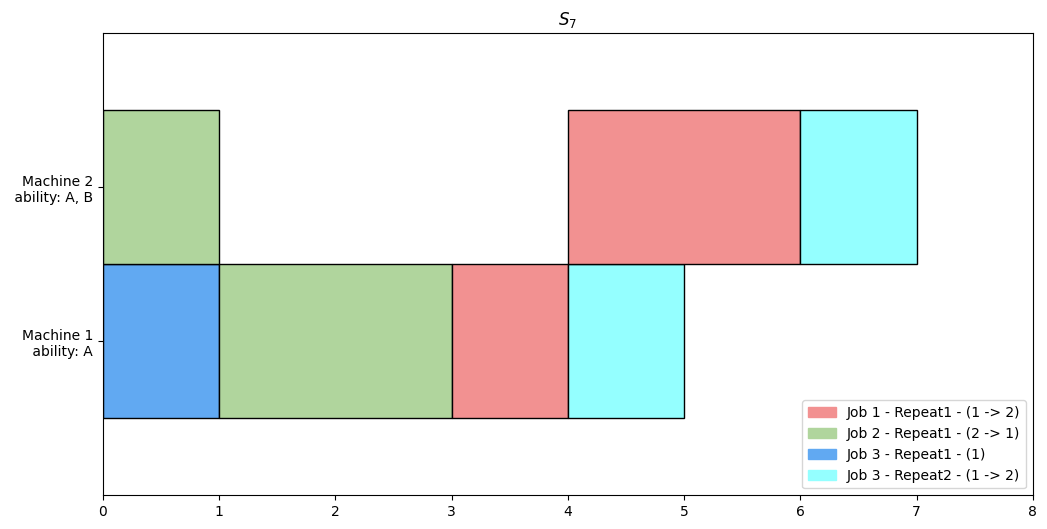

IndexError: list index out of range

In [24]:
step = 0
obs, info = env.reset()
#print(info['schedule_buffer'])

actions = [(2, 2), (3, 1), (2, 1), (1, 1), (1, 2), (3, 1), (3, 2)]
J = 3
M = 2

while True:
    action = actions[step]
    action = (action[0] - 1) + (action[1] - 1) * J
    # print(action)
    # action = env.action_space.sample()
    
    step += 1
    obs, reward, terminated, truncated, info = env.step(action)
    # print(f"action : {action // 3}, {action % 3}")
    # print(info['schedule_buffer'])
    # env.visualize_graph()
    done = terminated or truncated
    et = list(map(lambda x: x / 100, info['job_estimated_tardiness']))
    # print(f'Job 1 ET : {et[0], et[1]}')
    # print(f'Job 2 ET : {et[2], et[3]}')
    # print(f'Job 3 ET : {et[4], et[5]}')
    # print('job_deadline', info['job_deadline'])
    # print(f'Action mask : {info["action_mask"]}')
    for job_list in info['jobs']:
        for job in job_list:
            print(f'{job.name} - Repeat {job.index + 1} : ETD = {job.estimated_tardiness / 100}, D = {job.deadline}')
    print('finish_time', info['finish_time'])
    
    env.render()
    
    
    if done:
        print("Goal reached!", "final score=", reward)
        print('finish_time', info['finish_time'])
        print('machine_operation_rate', info['machine_operation_rate'])
        print('job_deadline', info['job_deadline'])
        print('job_time_exceeded', info['job_time_exceeded'])
        print('current_repeats', info['current_repeats'])
        print(env.target_time)
        break

In [ ]:
# job_paths와 machine_paths를 포함하는 목록
# job_paths = ["instances/Jobs/v0-12-repeat-easy.json"]
# machine_paths = ["instances/Machines/v0-8.json"]

# def make_env(job_path, machine_path, test_mode, job_repeats_params):
#     def _init():
#         env = SchedulingEnv(job_config_path=job_path, machine_config_path=machine_path, job_repeats_params = job_repeats_params, test_mode = test_mode)
#         return Monitor(env)
#     return _init

# envs = [make_env(job_paths[0], machine_paths[0], False, [(3, 1)]*12), make_env(job_paths[0], machine_paths[0], False, [(3, 1)]*12)]

# vec_env = SubprocVecEnv(envs)
from train.make_env import make_env


cost_list = [5, 2, 1, 10]
profit_per_time = 10
max_time = 150

env1, env_name = make_env(num_machines=8, num_jobs=12, max_repeats=12,
                          repeat_means=[3] * 12, repeat_stds=[1] * 12, test_mode=False, cost_list=cost_list, profit_per_time=profit_per_time, max_time=max_time)

vec_env = env1

In [5]:
log_path = "./logs/tmp/1"
# set up logger
new_logger = configure(log_path, ["stdout", "csv", "tensorboard"])

env1, _ = make_env(num_machines=8, num_jobs=12, max_repeats=12, repeat_means=[
                   3] * 12, repeat_stds=[1] * 12, test_mode=False, cost_list=cost_list, profit_per_time=profit_per_time, max_time=max_time)


def env1_lambda(): return env1


env_list = [env1_lambda]
# Create the evaluation environment
eval_env = SubprocVecEnv(env_list)

# Create the EvalCallback
eval_callback = MaskableEvalCallback(eval_env, best_model_save_path=log_path,
                                     log_path=log_path, eval_freq=10000,
                                     deterministic=True, render=False)

Logging to ./logs/tmp/1


In [6]:
params = {
    "policy_kwargs": dict(net_arch=[dict(pi=[256, 64], vf=[256, 64])]),
    "gamma": 1.0,
    "clip_range": 0.1,
    "n_steps": 4096,
    "learning_rate": 0.0007,
}

model = MaskablePPO('MultiInputPolicy', vec_env,
                    policy_kwargs=params["policy_kwargs"],
                    verbose=1)
model.set_logger(new_logger)
model.learn(1_000_000, callback=eval_callback)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 94.8     |
|    ep_rew_mean     | -9.81    |
| time/              |          |
|    fps             | 469      |
|    iterations      | 1        |
|    time_elapsed    | 4        |
|    total_timesteps | 2048     |
---------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 95.2       |
|    ep_rew_mean          | -10.5      |
| time/                   |            |
|    fps                  | 393        |
|    iterations           | 2          |
|    time_elapsed         | 10         |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.01310496 |
|    clip_fraction        | 0.106      |
|    clip_range           | 0.2        |
|    entropy_loss         | -3.19

In [7]:
env1 = SchedulingEnv(machine_config_path= "instances/Machines/v0-8.json", job_config_path = "instances/Jobs/v0-12-repeat-easy.json", job_repeats_params = [(3, 1)] * 12, test_mode = True)
env2 = SchedulingEnv(machine_config_path= "instances/Machines/v0-8.json", job_config_path = "instances/Jobs/v0-12-repeat-easy.json", job_repeats_params = [(3, 1)] * 12, test_mode = False)

custom_env = [env1, env2]

Current Repeats			:	[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
Goal reached! Final score	:	24.00
Total revenue			:	2400.00 - 1824.00 = 576.00
Sum of Costs			:	1824.00
Cost Deadline			:	880.00
Cost Hole			:	24.00
Cost Processing			:	480.00
Cost Makespan			:	440.00
Finish Time / Target Time	:	4400 / 3000
Average Tardiness:	163.89


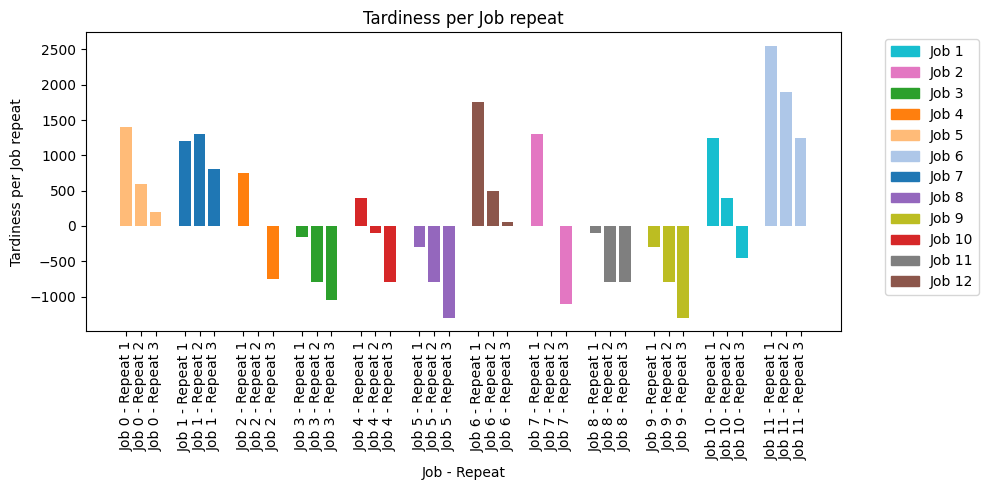

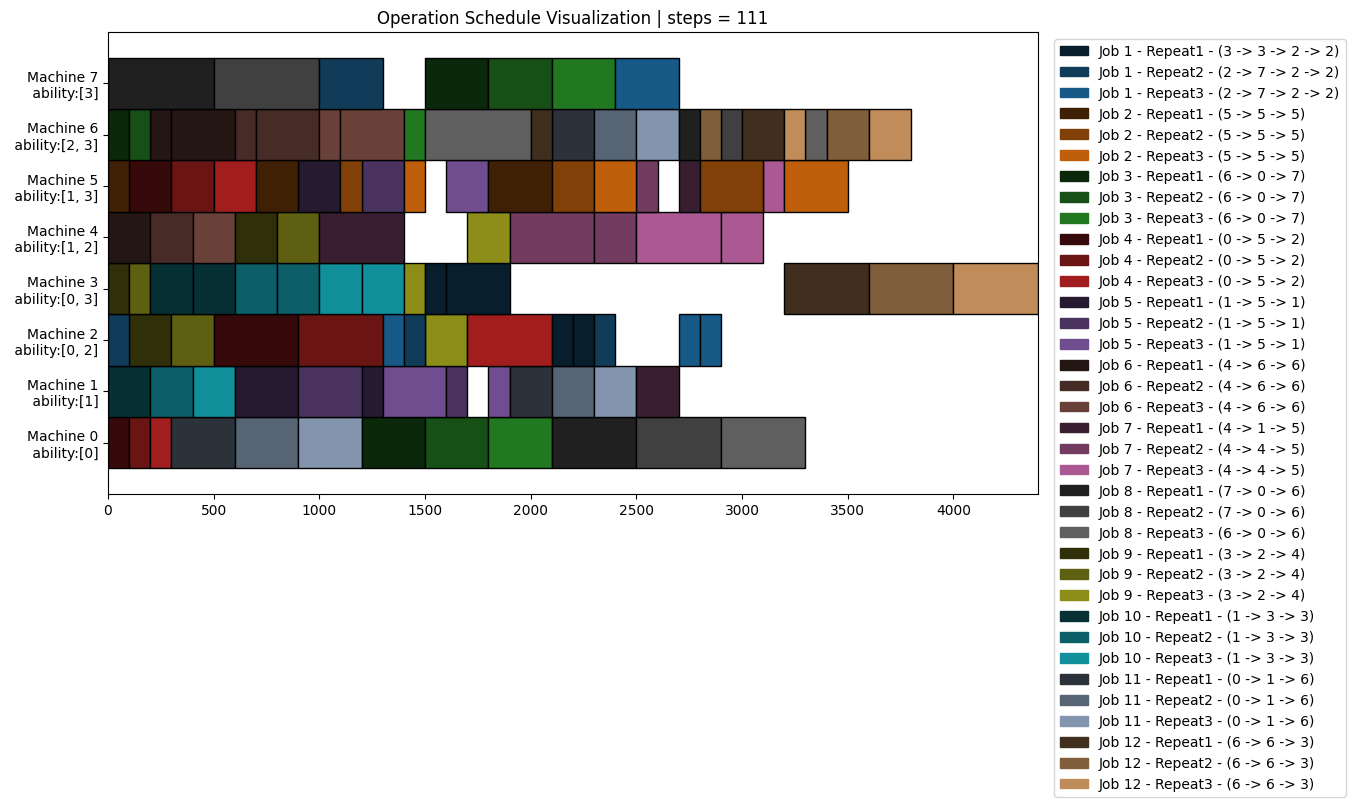

Current Repeats			:	[1, 4, 3, 3, 2, 3, 3, 3, 6, 2, 4, 4]
Goal reached! Final score	:	24.16
Total revenue			:	2510.00 - 1903.50 = 606.50
Sum of Costs			:	1903.50
Cost Deadline			:	927.50
Cost Hole			:	34.00
Cost Processing			:	502.00
Cost Makespan			:	440.00
Finish Time / Target Time	:	4400 / 3137
Average Tardiness:	-18.42


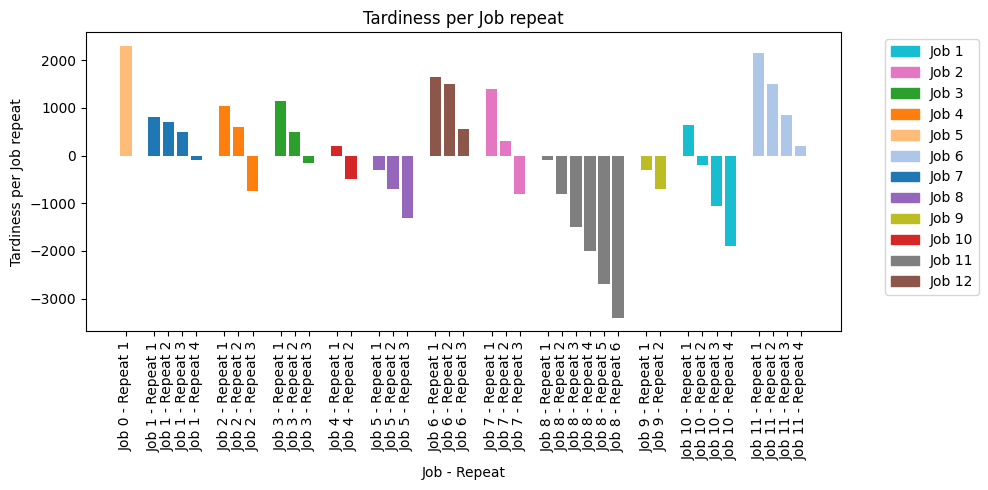

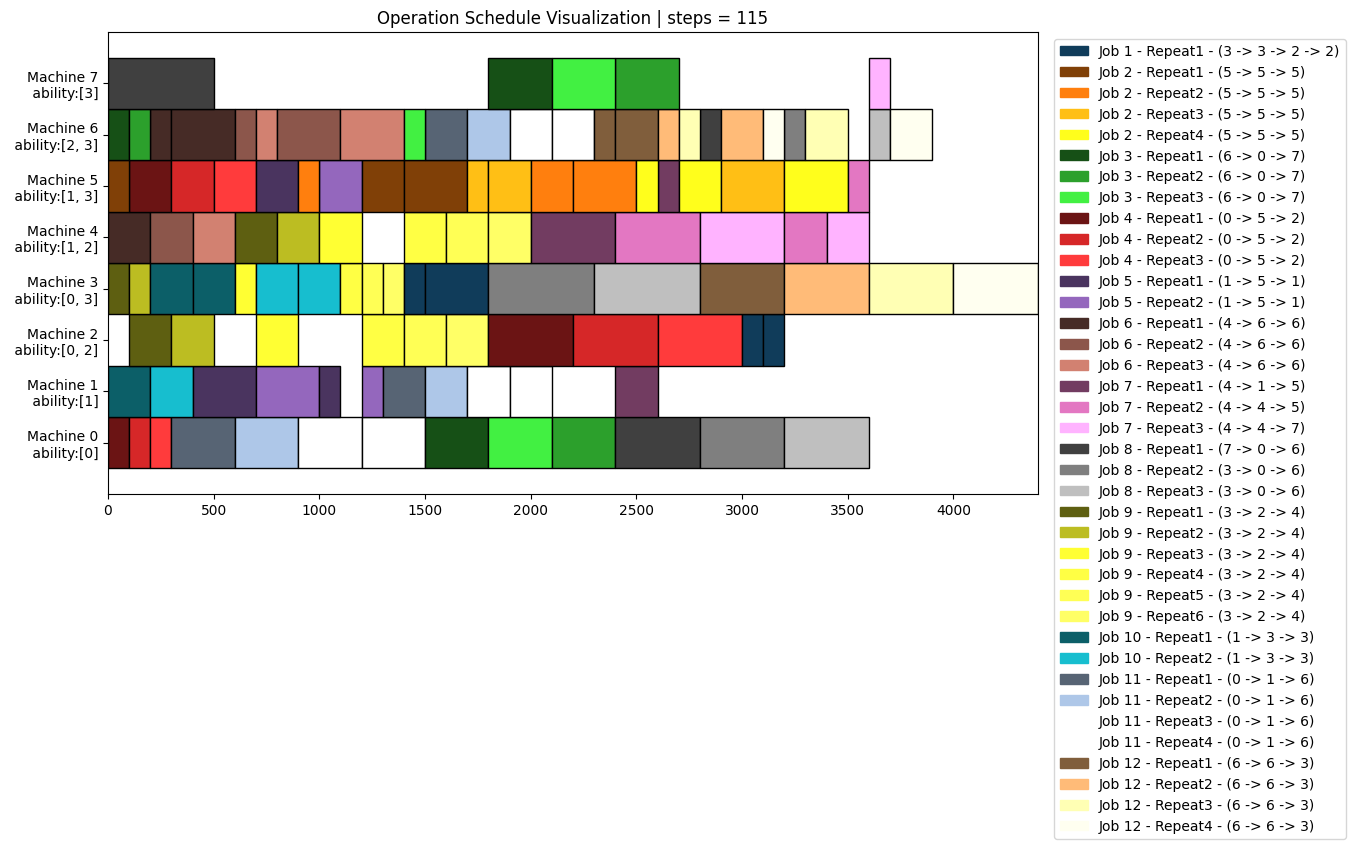

In [8]:
for env in custom_env:
    obs, info = env.reset()
    while True:
        action, _ = model.predict(obs, deterministic = True, action_masks = env.action_masks())
        obs, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        if done:
            # print("Goal reached!", "final score=", reward)
            # print('job_deadline', info['job_deadline'])
            # print('job_time_exceeded', info['job_time_exceeded'])
            # print('current_repeats', info['current_repeats'])
            # print(env.target_time)
            info["reward"] = reward
            info["env"] = env
            info["profit_ratio"] = env.profit_per_time
            env.print_result(info, detail_mode = False)
            env.render()
            break

In [ ]:
model.save("PPO_random_repeat")